In [58]:
# -*- coding: utf-8 -*-
"""
Created on Wed Sep 15 17:28:25 2021

@author: barraly
"""

import csv
import numpy as np
import matplotlib.pyplot as plt
# Set the font in the graphs
plt.rcParams["font.family"] = 'times new roman'
import matplotlib.cm as cm
import matplotlib.colors as clrs
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Polygon
import pandas as pd
from numpy import pi
import pylab
import scipy.spatial
import matplotlib.patheffects as pe
from matplotlib.cm import ScalarMappable

# Prepare the color map 
cmap = cm.get_cmap('RdYlBu_r', 500)

# The cmap is an array with the colors
cmin = -50
cmax = 200
color_min = cmap(0)
color_max = cmap(500)
pos_0 = -cmin/(cmax-cmin)
color_0 = cmap(0.5)
cmap = clrs.LinearSegmentedColormap.from_list('custom diverging', 
                                             [(0,    color_min),
                                              (pos_0, color_0),
                                              (1,    color_max)], N=500)

newcolors = cmap(np.linspace(0, 1, 500))
index_0 = int(-cmin / (cmax-cmin) * 500)
newcolors[index_0 - 1 : index_0 + 1] = [0, 0, 0, 0]
newcmp = clrs.ListedColormap(newcolors)

def cmap_percentage(cmin = -50, cmax = 100):
    # Prepare the color map 
    cmap = cm.get_cmap('RdYlBu_r', 500)
    
    # The cmap is an array with the colors
    color_min = cmap(0)
    color_max = cmap(500)
    pos_0 = -cmin/(cmax-cmin)
    color_0 = cmap(0.5)
    cmap = clrs.LinearSegmentedColormap.from_list('custom diverging', 
                                                 [(0,    color_min),
                                                  (pos_0, color_0),
                                                  (1,    color_max)], N=500)

    newcolors = cmap(np.linspace(0, 1, 500))
    index_0 = int(-cmin / (cmax-cmin) * 500)
    newcolors[index_0 - 1 : index_0 + 1] = [0, 0, 0, 0]
    newcmp = clrs.ListedColormap(newcolors)
    return newcmp

C:\Users\yann2\AppData\Local\Temp\ipykernel_35384\1951218982.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlBu_r', 500)


In [59]:
# In[Load the data]
data_CiPA = '../Experimental data/Summary table APD90 - CiPA.csv'
loaded_CiPA = pd.read_csv(data_CiPA, delimiter = ';')

data_Pharm = '../Experimental data/Summary table APD90 - Pharm.csv'
loaded_Pharm = pd.read_csv(data_Pharm, delimiter = ';')

# Fitting a quadratic surface through the points

In [60]:
import scipy.optimize
def surface(x, y, theta):
    return theta[0] * x**2  + theta[1] * y**2 + theta[2]*x*y + theta[3]*x + theta[4]*y #+ theta[5] * x**3 + theta[6] * y**3 + theta[7]*x**2*y + theta[8]*y**2*x 
    

In [61]:
# Find the optimal quadratic surface that matches the data
def constraints_verified(theta):
    # Force a monotonous surface
    x = np.linspace(0, 100, 101)
    y = np.linspace(0, 100, 101)
    surface_sim = np.transpose(surface(x[:, None], y, theta))
    
    # Check the corners
    if surface_sim[0, -1] < 200 or surface_sim[-1, 0] > -50:
        return False
    
    # Compute the derivate for each point
    dfdx = surface_sim[:, 1:] - surface_sim[:, :-1]
    dfdy = surface_sim[1:, :] - surface_sim[:-1, :]
    
    if np.any(dfdx < 0) or np.any(dfdy > 0):
        return False
    
    return True

def surface_score(theta, *loaded): 
    loaded = loaded[0]
    # Get the coordinates of points
    xs = np.array(loaded['IKr block'])
    ys = np.array(loaded['ICaL block'])
    
    
    # Initialise the output
    scores = np.zeros(len(xs))
    
    # Compute the score
    scores = (surface(xs, ys, theta) - np.array(loaded['Delta APD90'])) / np.array(loaded['Sigma'])
    
    # Check the constraints
    if not constraints_verified(theta):
        scores *= 100
    return np.sum(np.power(abs(scores), 1))

# Initialise the surface
theta_0 = [0.0] * 5
print('Initial guess : ' + str(theta_0))

res = scipy.optimize.differential_evolution(surface_score, 
                                            bounds = ([(-5, 5) for _ in range(5)]),
                                            x0=theta_0, 
                                            args=(loaded_CiPA, ))
theta_CiPA = res.x
print('Optimal theta: ' + str(theta_CiPA))
print('Score for optimal surface: ' + str(res.fun))
print('Constraints are verified for CiPA map: ' + str(constraints_verified(theta_CiPA)))

res = scipy.optimize.differential_evolution(surface_score, 
                                            bounds = ([(-5, 5) for _ in range(5)]),
                                            x0=theta_0, 
                                            args=(loaded_Pharm, ))
theta_Pharm = res.x
print('\nOptimal theta: ' + str(theta_Pharm))
print('Score for optimal surface: ' + str(res.fun))
print('Constraints are verified for Pharm map: ' + str(constraints_verified(theta_Pharm)))


Initial guess : [0.0, 0.0, 0.0, 0.0, 0.0]
Optimal theta: [ 0.00473036  0.00643546 -0.01535679  1.5316045  -1.29290445]
Score for optimal surface: 35.47870194388871
Constraints are verified for CiPA map: True

Optimal theta: [ 1.80709908e-03  6.06437592e-03 -1.81770297e-02  1.82206121e+00
 -1.21568999e+00]
Score for optimal surface: 42.49407832309855
Constraints are verified for Pharm map: True


In [62]:
x = np.linspace(0, 100, 101)
y = np.linspace(0, 100, 101)
surface_CiPA = np.transpose(surface(x[:, None], y, theta_CiPA))
surface_Pharm = np.transpose(surface(x[:, None], y, theta_Pharm))

#x = np.linspace(0, 100, 101)
#y = np.linspace(0, 100, 101)
#surface_sim = surface(x[:, None], y, theta_0)
#print(np.shape(surface_sim))
#print(surface_sim[100, 0])

# Plot the map of Delta APD_90

C:\Users\yann2\AppData\Local\Temp\ipykernel_35384\4201915186.py:99: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plot_map(loaded_CiPA['IKr block'], loaded_CiPA['ICaL block'], loaded_CiPA['Sigma'], ax=ax, cmap = cm.get_cmap('Greens'), cmin = 0 ,cmax = 100)
C:\Users\yann2\AppData\Local\Temp\ipykernel_35384\4201915186.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plot_map(loaded_Pharm['IKr block'], loaded_Pharm['ICaL block'], loaded_Pharm['Sigma'], ax=ax, cmap = cm.get_cmap('Greens'), cmin = 0, cmax = 100)
C:\Users\yann2\AppData\Local\Temp\ipykernel_35384\4201915186.py:115: MatplotlibDeprecationWarning: The get_cmap function was deprecated 

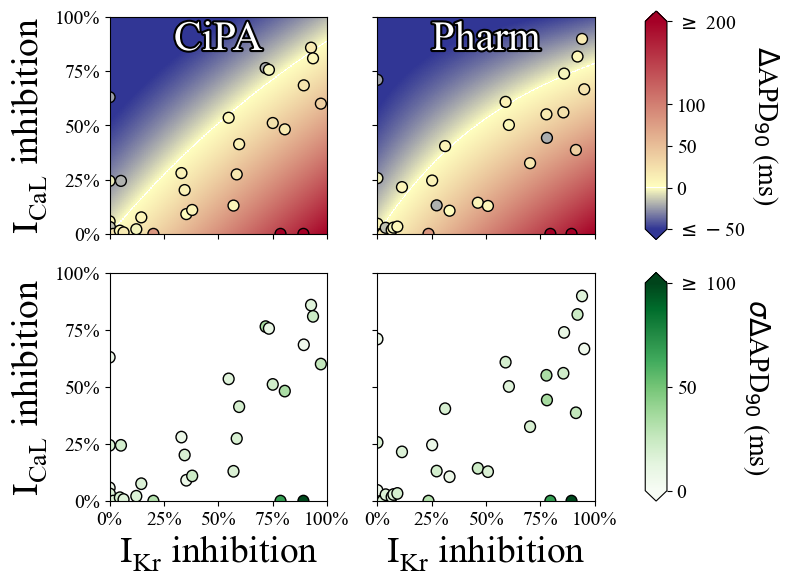

In [63]:
# In[Plot the validation samples]
def plot_map(IKr_inhibitions, ICaL_inhibitions, DAPDs, cmin = -50, cmax = 200, ax=None, cmap = cmap):
    # Define the figure
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize = (8, 8))
            
    # Add the map of exp points
    radius = 5
    for j in range(len(DAPDs)):
        e = patches.Ellipse((IKr_inhibitions[j], ICaL_inhibitions[j]), radius, radius, alpha = 1)
        e.set_edgecolor(color = 'k')
        col = cmap((DAPDs[j]-cmin) / (cmax-cmin))
        e.set_facecolor(col)
        ax.add_artist(e)
    ax.autoscale()
    
    # Axes
    ax.set_xlabel('$\mathregular{I_{Kr}}$ inhibition', fontsize = 27)
    ax.set_ylabel('$\mathregular{I_{CaL}}$ inhibition', fontsize = 27)
    ax.set_xlim([0, 100])
    ax.set_ylim([0, 100])
    ax.set_xticks([0, 25, 50, 75, 100])
    ax.set_xticklabels(['0%', '25%', '50%', '75%', '100%'])
    ax.set_yticks([0, 25, 50, 75, 100])
    ax.set_yticklabels(['0%', '25%', '50%', '75%', '100%'])
    ax.tick_params(labelsize = 14)
    
    return None

def plot_map_and_surface(IKr_inhibitions, ICaL_inhibitions, DAPDs, surface, cmin = -50, cmax = 200, ax=None, cmap = cmap):
    # Define the figure
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize = (8, 8))
        
    # Plot the quadratic surface
    ax.imshow(surface, origin = 'lower', cmap=cmap, vmin=cmin, vmax=cmax)
    

    
    # Add the map of exp points
    radius = 5
    for j in range(len(DAPDs)):
        e = patches.Ellipse((IKr_inhibitions[j], ICaL_inhibitions[j]), radius, radius, alpha = 1)
        e.set_edgecolor(color = 'k')
        col = cmap((DAPDs[j]-cmin) / (cmax-cmin))
        e.set_facecolor(col)
        ax.add_artist(e)
    ax.autoscale()
    
    # Axes
    ax.set_xlabel('$\mathregular{I_{Kr}}$ inhibition', fontsize = 27)
    ax.set_ylabel('$\mathregular{I_{CaL}}$ inhibition', fontsize = 27)
    ax.set_xlim([0, 100])
    ax.set_ylim([0, 100])
    ax.set_xticks([0, 25, 50, 75, 100])
    ax.set_xticklabels(['0%', '25%', '50%', '75%', '100%'])
    ax.set_yticks([0, 25, 50, 75, 100])
    ax.set_yticklabels(['0%', '25%', '50%', '75%', '100%'])
    ax.tick_params(labelsize = 14)
    
    return None

# Desing the figure
mosaic = [['CiPA DAPD', 'Pharm DAPD', 'cbar DAPD'],
         ['CiPA std', 'Pharm std', 'cbar std']]
fig, axes = plt.subplot_mosaic(mosaic, figsize = (8, 6), gridspec_kw=dict(width_ratios=[1, 1, 0.1], height_ratios=[1, 1]))
fig.patch.set_facecolor('white')
# CiPA
ax = axes['CiPA DAPD']
plot_map_and_surface(loaded_CiPA['IKr block'], loaded_CiPA['ICaL block'], loaded_CiPA['Delta APD90'], surface_CiPA, ax=ax, cmap = newcmp)
ax.text(x=50, y = 98, s = 'CiPA', fontsize = 30, color = 'white', ha = 'center', va = 'top', path_effects=[pe.withStroke(linewidth=3, foreground='black')])
ax.set_xticklabels(['', '', '', '', ''])
ax.set_xlabel('')

# Pharm
ax = axes['Pharm DAPD']
plot_map_and_surface(loaded_Pharm['IKr block'], loaded_Pharm['ICaL block'], loaded_Pharm['Delta APD90'], surface_Pharm, ax=ax, cmap = newcmp)
ax.text(x=50, y = 98, s = 'Pharm', fontsize = 30, color = 'white', ha = 'center', va = 'top', path_effects=[pe.withStroke(linewidth=3, foreground='black')])
ax.set_ylabel('')
ax.set_yticklabels(['', '', '', '', ''])
ax.set_xticklabels(['', '', '', '', ''])
ax.set_xlabel('')

# Add the legend
ax = axes['cbar DAPD']
norm = plt.Normalize(-50, 200)

sm =  ScalarMappable(norm=norm, cmap=newcmp)
sm.set_array([])

cbar = fig.colorbar(sm, extend = 'both', cax = ax)
cbar.set_ticks([-50, 0, 50, 100, 200])
cbar.ax.set_yticklabels(['$\leq -$50', 0, 50, 100, '$\geq$ 200'], fontsize = 14)
cbar.set_label('$\Delta$APD$_{90}$ (ms)', rotation=270, fontsize = 20, labelpad = 25)


# CiPA std
ax = axes['CiPA std']
plot_map(loaded_CiPA['IKr block'], loaded_CiPA['ICaL block'], loaded_CiPA['Sigma'], ax=ax, cmap = cm.get_cmap('Greens'), cmin = 0 ,cmax = 100)
#ax.text(x=50, y = 98, s = 'CiPA', fontsize = 35, color = 'white', ha = 'center', va = 'top',
#       path_effects=[pe.withStroke(linewidth=3, foreground='black')])


# CiPA std
ax = axes['Pharm std']
plot_map(loaded_Pharm['IKr block'], loaded_Pharm['ICaL block'], loaded_Pharm['Sigma'], ax=ax, cmap = cm.get_cmap('Greens'), cmin = 0, cmax = 100)
#ax.text(x=50, y = 98, s = 'Pharm', fontsize = 35, color = 'white', ha = 'center', va = 'top',
#       path_effects=[pe.withStroke(linewidth=3, foreground='black')])
ax.set_ylabel('')
ax.set_yticklabels(['', '', '', '', ''])

# Add the legend
ax = axes['cbar std']
norm = plt.Normalize(0, 100)
sm =  ScalarMappable(cmap=cm.get_cmap('Greens'), norm = norm)
sm.set_array([])

cbar = fig.colorbar(sm, extend = 'both', cax = ax)
cbar.set_ticks([0, 50, 100])
cbar.ax.set_yticklabels([0, 50, '$\geq$ 100'], fontsize = 14)
cbar.set_label('$\sigma \Delta$APD$_{90}$ (ms)', rotation=270, fontsize = 20, labelpad = 25)


# Save
save_name = 'DAPD experimental benchmark quadratic surface'
plt.tight_layout()
plt.savefig(save_name + '.png', dpi = 300, transparent=True)
plt.savefig(save_name + '.pdf', format = 'pdf', transparent=True)


# Repeat with the percentage of change of Delta APD_90

In [64]:
# In[Load the data]
data_CiPA_percent = '../Experimental data/Summary table APD90 - CiPA - percentage.csv'
loaded_CiPA_percent = pd.read_csv(data_CiPA_percent, delimiter = ';')

data_Pharm_percent = '../Experimental data/Summary table APD90 - Pharm - percentage.csv'
loaded_Pharm_percent = pd.read_csv(data_Pharm_percent, delimiter = ';')

In [65]:
# Find the optimal quadratic surface that matches the data
def constraints_verified(theta):
    # Force a monotonous surface
    x = np.linspace(0, 100, 101)
    y = np.linspace(0, 100, 101)
    surface_sim = np.transpose(surface(x[:, None], y, theta))
    
    # Check the corners
    if surface_sim[0, -1] < 100 or surface_sim[-1, 0] > -50:
        return False
    
    # Compute the derivate for each point
    dfdx = surface_sim[:, 1:] - surface_sim[:, :-1]
    dfdy = surface_sim[1:, :] - surface_sim[:-1, :]
    
    if np.any(dfdx < 0) or np.any(dfdy > 0):
        return False
    
    return True

def surface_score(theta, *loaded): 
    loaded = loaded[0]
    # Get the coordinates of points
    xs = np.array(loaded['IKr block'])
    ys = np.array(loaded['ICaL block'])
    
    
    # Initialise the output
    scores = np.zeros(len(xs))
    
    # Compute the score
    scores = (surface(xs, ys, theta) - np.array(loaded['Percentage DAPD90'])) / np.array(loaded['Sigma'])
    
    # Check the constraints
    if not constraints_verified(theta):
        scores *= 100
    return np.sum(np.power(abs(scores), 1))

np.random.seed(1234)
theta_0 = np.random.uniform(low = -5, high = 5, size=5) 
print('Initial guess : ' + str(theta_0))

res = scipy.optimize.differential_evolution(surface_score, bounds = ([(-5, 5) for _ in range(5)]),
                                            x0=theta_0, args=(loaded_CiPA_percent, ))
theta_CiPA_percent = res.x
print('Optimal theta: ' + str(theta_CiPA_percent))
print('Score for optimal surface: ' + str(res.fun))
print('Constraints are verified for CiPA map: ' + str(constraints_verified(theta_CiPA_percent)))

res = scipy.optimize.differential_evolution(surface_score, bounds = ([(-5, 5) for _ in range(5)]),
                                            x0=theta_0, args=(loaded_Pharm_percent, ))
theta_Pharm_percent = res.x
print('\nOptimal theta: ' + str(theta_Pharm_percent))
print('Score for optimal surface: ' + str(res.fun))
print('Constraints are verified for Pharm map: ' + str(constraints_verified(theta_Pharm_percent)))


Initial guess : [-3.0848055   1.22108771 -0.62272261  2.85358584  2.79975808]
Optimal theta: [ 4.87288808e-03  1.87921615e-04 -5.17710463e-03  5.12989763e-01
 -5.20723729e-01]
Score for optimal surface: 52.994382585991666
Constraints are verified for CiPA map: True

Optimal theta: [ 2.72015272e-03  4.69001170e-04 -7.23805007e-03  7.28580993e-01
 -5.47575482e-01]
Score for optimal surface: 63.32072195885324
Constraints are verified for Pharm map: True


In [66]:
x = np.linspace(0, 100, 101)
y = np.linspace(0, 100, 101)
surface_CiPA_percent = np.transpose(surface(x[:, None], y, theta_CiPA_percent))
surface_Pharm_percent = np.transpose(surface(x[:, None], y, theta_Pharm_percent))

#x = np.linspace(0, 100, 101)
#y = np.linspace(0, 100, 101)
#surface_sim = surface(x[:, None], y, theta_0)
#print(np.shape(surface_sim))
#print(surface_sim[100, 0])

C:\Users\yann2\AppData\Local\Temp\ipykernel_35384\1951218982.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlBu_r', 500)
C:\Users\yann2\AppData\Local\Temp\ipykernel_35384\61981924.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plot_map(loaded_CiPA['IKr block'], loaded_CiPA['ICaL block'], loaded_CiPA['Sigma'], ax=ax, cmap = cm.get_cmap('Greens'), cmin = 0 ,cmax = 100)
C:\Users\yann2\AppData\Local\Temp\ipykernel_35384\61981924.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.c

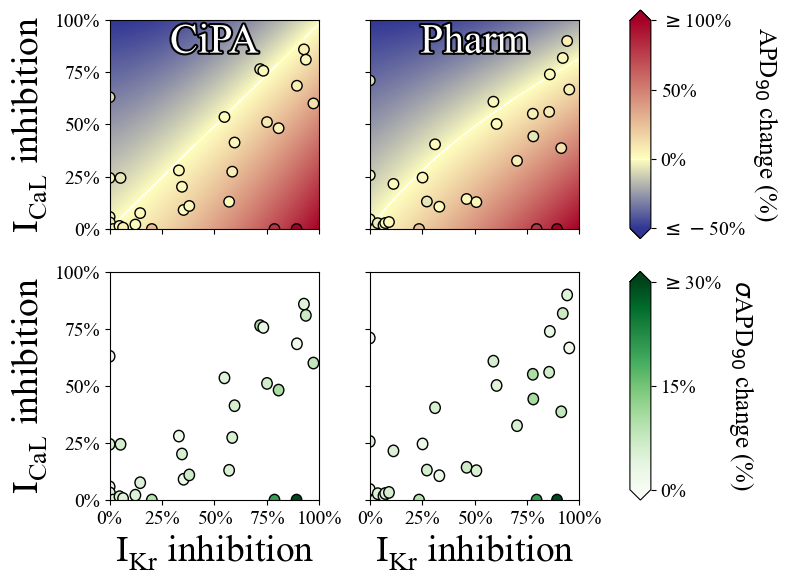

In [67]:
# In[Plot the validation samples]
# Design the figure
mosaic = [['CiPA DAPD', 'Pharm DAPD', 'cbar DAPD'],
         ['CiPA std', 'Pharm std', 'cbar std']]
fig, axes = plt.subplot_mosaic(mosaic, figsize = (8, 6), gridspec_kw=dict(width_ratios=[1, 1, 0.1], height_ratios=[1, 1]))
fig.patch.set_facecolor('white')
# CiPA
ax = axes['CiPA DAPD']
plot_map_and_surface(loaded_CiPA_percent['IKr block'], loaded_CiPA_percent['ICaL block'], 
                     loaded_CiPA_percent['Percentage DAPD90'], surface_CiPA_percent, ax=ax, cmap = cmap_percentage(),
                     cmin = -50, cmax = 100)
ax.text(x=50, y = 98, s = 'CiPA', fontsize = 30, color = 'white', ha = 'center', va = 'top', path_effects=[pe.withStroke(linewidth=3, foreground='black')])
ax.set_xticklabels(['', '', '', '', ''])
ax.set_xlabel('')

# Pharm
ax = axes['Pharm DAPD']
plot_map_and_surface(loaded_Pharm_percent['IKr block'], loaded_Pharm_percent['ICaL block'], 
                     loaded_Pharm_percent['Percentage DAPD90'], surface_Pharm_percent, ax=ax, cmap = cmap_percentage(),
                     cmin = -50, cmax = 100)
ax.text(x=50, y = 98, s = 'Pharm', fontsize = 30, color = 'white', ha = 'center', va = 'top', path_effects=[pe.withStroke(linewidth=3, foreground='black')])
ax.set_ylabel('')
ax.set_yticklabels(['', '', '', '', ''])
ax.set_xticklabels(['', '', '', '', ''])
ax.set_xlabel('')

# Add the legend
ax = axes['cbar DAPD']
norm = plt.Normalize(-50, 100)

sm =  ScalarMappable(norm=norm, cmap=cmap_percentage())
sm.set_array([])

cbar = fig.colorbar(sm, extend = 'both', cax = ax)
cbar.set_ticks([-50, 0, 50, 100])
cbar.ax.set_yticklabels(['$\leq -$50%', '0%', '50%', '$\geq$100%'], fontsize = 14)
cbar.set_label('APD$_{90}$ change (%)', rotation=270, fontsize = 18, labelpad = 25)


# CiPA std
ax = axes['CiPA std']
plot_map(loaded_CiPA['IKr block'], loaded_CiPA['ICaL block'], loaded_CiPA['Sigma'], ax=ax, cmap = cm.get_cmap('Greens'), cmin = 0 ,cmax = 100)
#ax.text(x=50, y = 98, s = 'CiPA', fontsize = 30, color = 'white', ha = 'center', va = 'top',
#       path_effects=[pe.withStroke(linewidth=3, foreground='black')])


# CiPA std
ax = axes['Pharm std']
plot_map(loaded_Pharm['IKr block'], loaded_Pharm['ICaL block'], loaded_Pharm['Sigma'], ax=ax, cmap = cm.get_cmap('Greens'), cmin = 0, cmax = 100)
#ax.text(x=50, y = 98, s = 'Pharm', fontsize = 30, color = 'white', ha = 'center', va = 'top',
#       path_effects=[pe.withStroke(linewidth=3, foreground='black')])
ax.set_ylabel('')
ax.set_yticklabels(['', '', '', '', ''])

# Add the legend
ax = axes['cbar std']
norm = plt.Normalize(0, 30)
sm =  ScalarMappable(cmap=cm.get_cmap('Greens'), norm = norm)
sm.set_array([])

cbar = fig.colorbar(sm, extend = 'both', cax = ax)
cbar.set_ticks([0, 15, 30])
cbar.ax.set_yticklabels(['0%', '15%', '$\geq$30%'], fontsize = 14)
cbar.set_label('$\sigma$APD$_{90}$ change (%)', rotation=270, fontsize = 18, labelpad = 25)


# Save
save_name = 'DAPD experimental benchmark quadratic surface - percentage'
plt.tight_layout()
plt.savefig(save_name + '.png', dpi = 300, transparent=True)
plt.savefig(save_name + '.pdf', format = 'pdf', transparent=True, bbox_inches = 'tight')
